# Project 3

In this project, we apply machine learning methods to predict Consumer Price Index. 

After obtaining the predicted CPI, we would then calculate monthly and yearly inflation.

## 1. Label Decomposition

Import necessary library

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss


In [79]:
# Read in the data

df = pd.read_csv('cpi.csv', parse_dates= [['Year', 'Month']], index_col= 'Year_Month')

# Change the index name to 'Date'
df.index.name = 'Date'

Visualize monthly and yearly inflation

Text(0.5, 1.0, '1-month inflation rate')

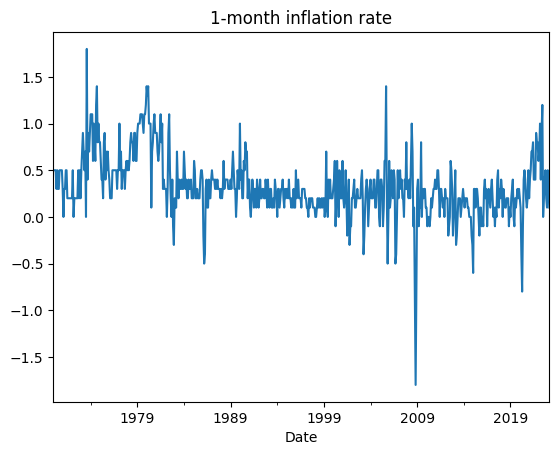

In [80]:
df['1-Month % Change'].plot()
plt.title('1-month inflation rate')

Text(0.5, 1.0, '12-month inflation rate')

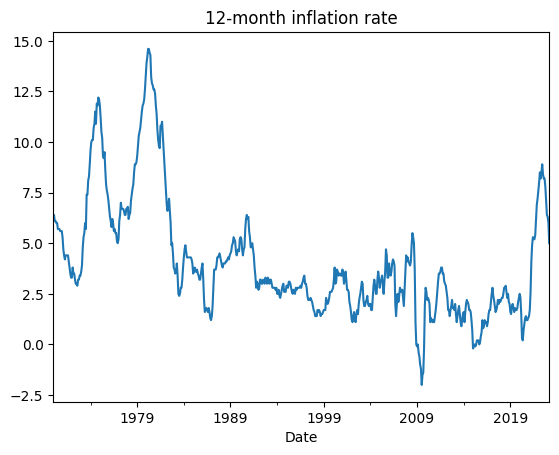

In [81]:
df['12-Month % Change'].plot()
plt.title('12-month inflation rate')

Our current main focus is the CPI index, so let's decompose this feature first.
- First, decompose the CPI column into trend, seasonal, and residual components using additive method. 
- Second, apply multiplicative method
- Since we may apply detrending method as a way to make the data stationary, we will be using backward looking moving average in order to smooth out the noise (instead of the center moving average) and reduce the number of future observation lost. 


In [82]:
df['CPI'].describe()

count    639.000000
mean     155.392549
std       71.156652
min       37.900000
25%       99.000000
50%      157.200000
75%      217.350000
max      301.808000
Name: CPI, dtype: float64

### 1.1 Additive decomposition

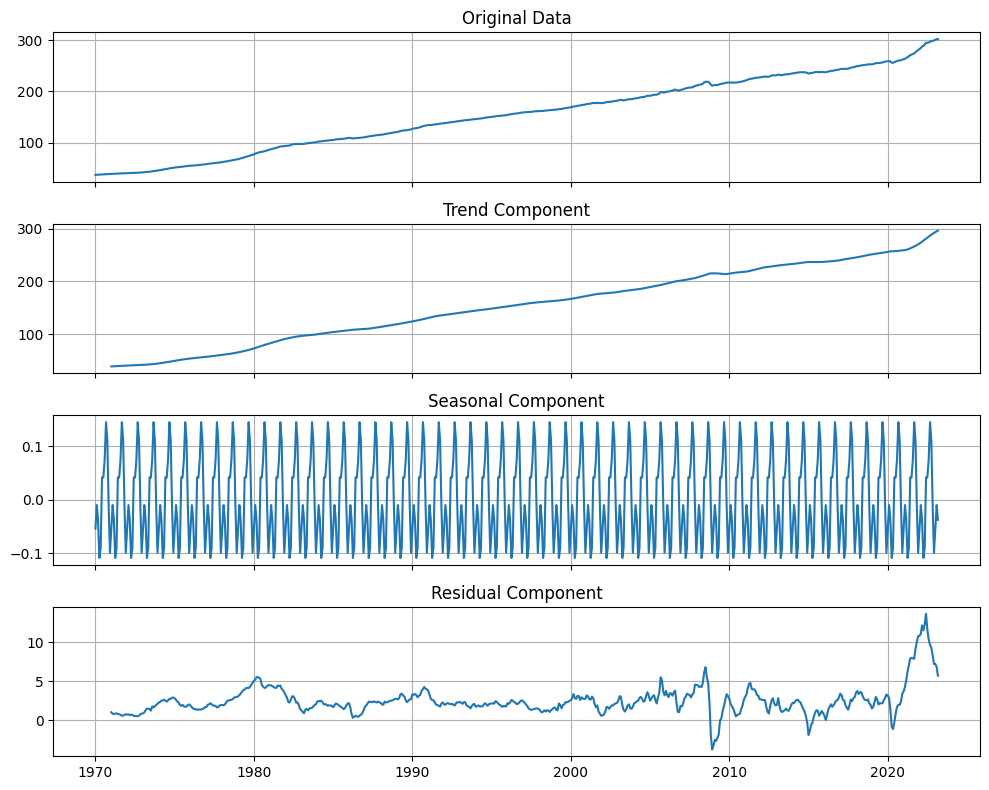

In [83]:
additive_decomposed = seasonal_decompose(df['CPI'], model='additive',two_sided= False, period= 12)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(additive_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(additive_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(additive_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


In this additive decomposition, we set the period to 12, which is quite common most economic time series data. After we have adjusted for multiple periods, this yearly seasonality seems to be the most approporiate. 

### 1.1.1 Additive decomp's findings
- Seasonal component appears to be minimal compared to the original data and doesn't contribute significantly to the overall patterns in the data. It might be reasonable to shift our focus to trend and residual components. 
- Residuals exploded during the Financial Crisis 2008-09 and early covid time until now.
- The hot inflation period starting in late 2021 seems to add a lot of noise to the trend, as shown by the spike in residual. 

A statistical look into the seasonal component

In [84]:
additive_decomposed.seasonal.describe()

count    639.000000
mean      -0.000159
std        0.079781
min       -0.108761
25%       -0.053850
50%       -0.013056
75%        0.041670
max        0.144558
Name: seasonal, dtype: float64

### 1.2 Multiplicative Decomposition

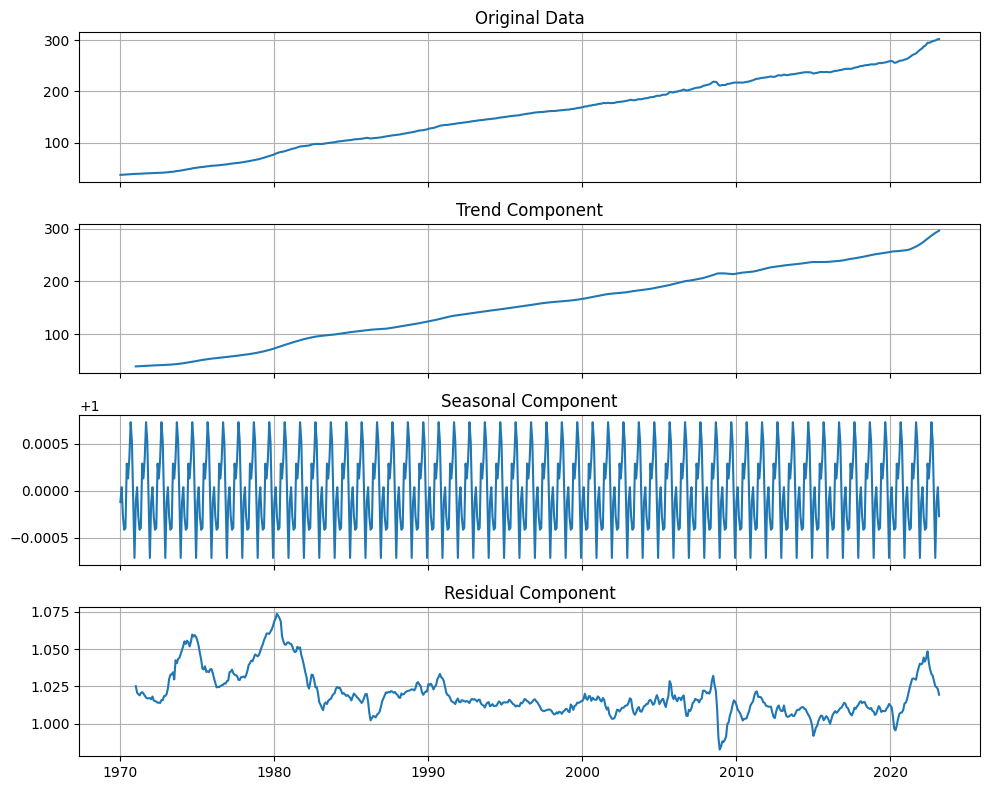

In [85]:
multiplicative_decomposed = seasonal_decompose(df['CPI'], model='multiplicative',two_sided= False, period= 12)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(multiplicative_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(multiplicative_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(multiplicative_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


### 1.2.1 Multiplicative decomp's findings

- Same conclusion as additive decomposition

Both multiplicative and additive decomposition show that the trend component is the most important component in the CPI index. 

However, residuals in the multiplicative decomposition is more stable than in additive approach, so we should move forward with mulitplicative approach. 

## 2. Trend Analysis

In [86]:
# Obtain statistical attributes of the trend component
additive_decomposed.trend.describe()

count    627.000000
mean     155.137797
std       69.487011
min       38.925000
25%       99.941667
50%      157.445833
75%      215.433771
max      296.124417
Name: trend, dtype: float64

Since the series has a linear trend, it is definitely not stationary. Thus, we should attempt to make it stationary.

In addition, we can address how statistical properties of a series change over time by visualizing. This would help us check the structural break and heteroscedasticity issue. 
- The rolling window size is 12 months

In [87]:
# Create a fucntion to plot rolling variance and rolling mean
def rolling_statistics(timeseries, custom_name, window_size=12):
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=window_size).mean()
    rolling_std = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_mean, color='black', label='Rolling Mean')
    plt.plot(rolling_std, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of ' + custom_name)
    plt.grid()
    plt.show()

### 2.1 Label Diffencing

First, let's work on differncing the data to see if the process can make the data more stationay. 

#### 2.1.1 First Order Differencing

In the first order differencing, we would subtract the immediate previous value from the current value to obtain the difference between two consecutive periods. 

First-Order Differencing = Value at time t - Value at time t-1

In [88]:
diff_data = df['CPI'].diff().dropna()


Text(0.5, 1.0, 'First - Order Differenced Data')

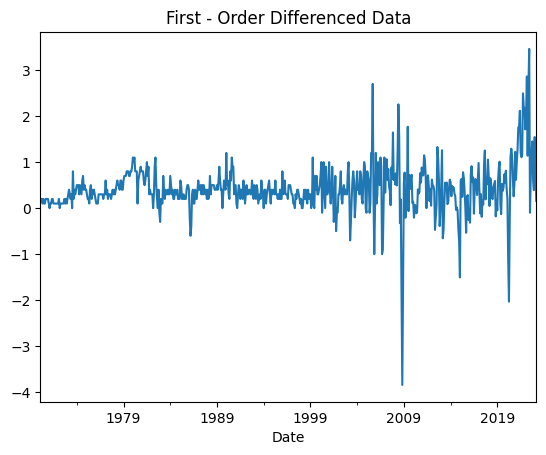

In [89]:
diff_data.plot()
plt.title('First - Order Differenced Data')

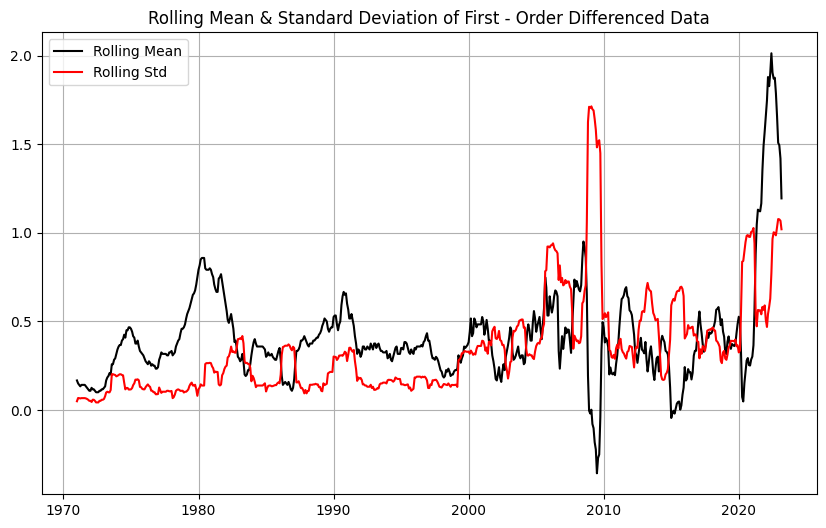

In [90]:
rolling_statistics(diff_data, 'First - Order Differenced Data')

#### 2.1.2 Second Order Differencing

In [91]:
second_order_diff = diff_data.diff().dropna()

Text(0.5, 1.0, 'Second - Order Differenced Data')

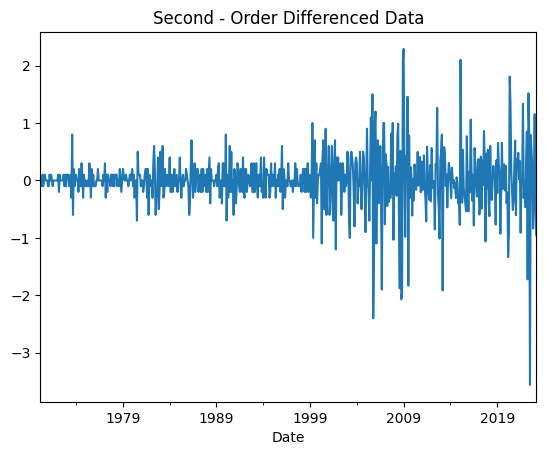

In [92]:
second_order_diff.plot()
plt.title('Second - Order Differenced Data')


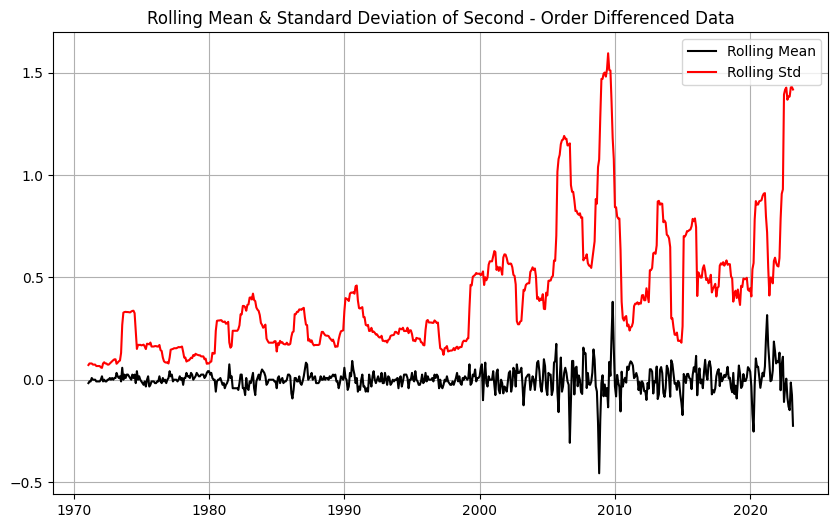

In [93]:
rolling_statistics(second_order_diff, 'Second - Order Differenced Data')

### 2.2 Label Detrending

- The default method for smoothing the trend component is centered moving average. 

- Since we use a period of 12 to smooth out the data, the function will use a centered moving average witha  window size of 12 to smooth the trend component (6 periods before and 6 periods after).

- As a result, we would lose 12 observations in using label detrending (first 6 observations, and the last 6 observations), compared to only 1 in first-order differencing.

- Detrended data is computed by subtracting the trend values from the actual values. 

In [94]:
# Here, I extract the trend component from the multiplicative decomposition. 
trend = multiplicative_decomposed.trend

In [95]:
detrend = df['CPI']- trend

detrend.dropna(inplace=True)

Text(0.5, 1.0, 'Detrended Data')

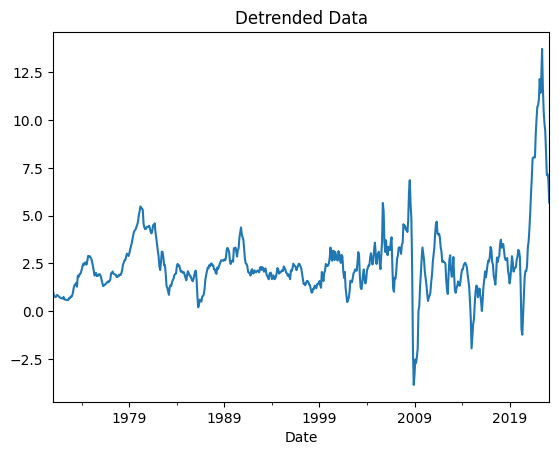

In [96]:
detrend.plot()
plt.title('Detrended Data')

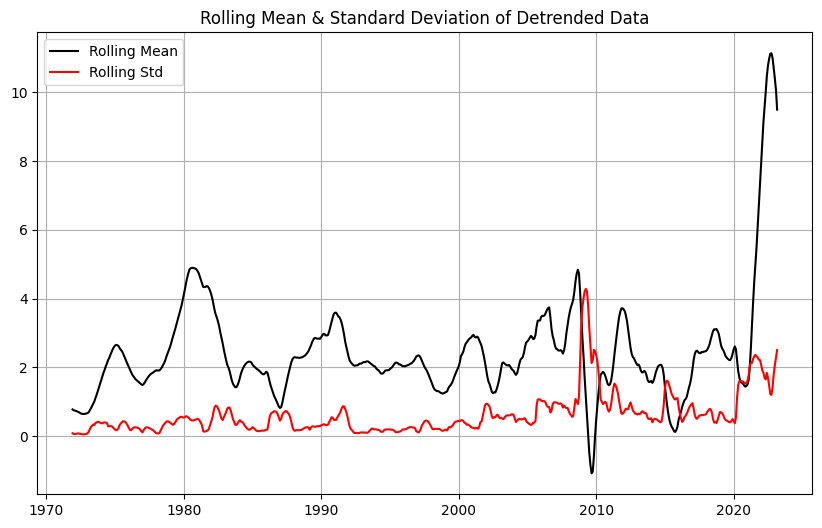

In [97]:
rolling_statistics(detrend, 'Detrended Data')

### 2.3 Differencing and Detrending Conclusion

- Though the trend appears to be linear and smooth, graphs from differenced values and detrending data CPI values after 1999 show an explosion in variance. 
- Besides, these graphs also illustrate even after CPI has been detrended or differenced it still does not appear to be stationary (variance does not look to be constant over time). 

## 3. Label Transformation (Make it stationary)

Create a function to calculate the ADF test and print out the result. 

In [98]:
def stationary_test(input):

    result = adfuller(input)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Reject the null hypothesis if the p-value is below the chosen significance level
    if result[1] < 0.05:
        print("The data is STATIONARY.")
    else:
        print("The data is NOT STATIONARY.")
        

In addition to the ADF test, let's use the non parametric KPSS test to confirm the stationarity of the data. If KPSS's result contradict conclusion from ADF, we need to investigate further. 

### 3.1 Augemnted Dickey-Fuller Test

To statistically verify if the data is stationary or not, we would deploy ADF test. 

- Null hypothesis: The time series contains a unit root and is non-stationary

- Alternative hypothesis is that the time series is stationary. 

To confirm that the data is stationary, we need a p-value that is lower than the significance level in order to reject the null hypothesis, and the critical values should be greater greater than the ADF statistics.

- The significance level chosen is 0.05. 

1. ADF on the orignal dataset

In [99]:
stationary_test(df['CPI'])

ADF Statistic: 1.0438548462388417
p-value: 0.9947077777984235
Critical Values: {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}
The data is NOT STATIONARY.


2. ADF on the first-order differenced dataset 

In [100]:
stationary_test(diff_data)

ADF Statistic: -3.65086044056224
p-value: 0.004859906697756279
Critical Values: {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}
The data is STATIONARY.


3. ADF on the second order differenced dataset

In [101]:
stationary_test(second_order_diff)

ADF Statistic: -11.000666146988296
p-value: 6.695157822541703e-20
Critical Values: {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}
The data is STATIONARY.


4. ADF on the detrended dataset

In [102]:
stationary_test(detrend)

ADF Statistic: -3.7881100079153582
p-value: 0.0030313349100589385
Critical Values: {'1%': -3.4410979308822967, '5%': -2.8662819588823423, '10%': -2.5692953639629166}
The data is STATIONARY.


### 3.2 Non-parametric KPSS test

- Null hypothesis: The time series is stationary (no unit root)

- Alternative hypothesis: The time series is stastionary (it has a unit root)

KPSS' test statistic is compared to the relevant critical values. If the test statistic is greater than the cirtical value at a chosen level of significance, we reject the null hypothesis  and conclude that the series is non-stationary with a unit root. 


In [103]:
# Create a function to perform the kpss test.
def kpss_test(input):
        result = kpss(input)
        print('KPSS Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[3])
    
        # Reject the null hypothesis if the p-value is below the chosen significance level
        if result[1] < 0.05:
            print("The data is NOT STATIONARY.")
        else:
            print("The data is STATIONARY.")


1. KPSS test on the orignal data

In [104]:
kpss_test(df['CPI'])

KPSS Statistic: 3.8444008961699514
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is NOT STATIONARY.


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


2. KPSS test on the first-order differenced data

In [105]:
kpss_test(diff_data)

KPSS Statistic: 0.38154798869761897
p-value: 0.08510862556137114
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is STATIONARY.


Note here, if we choose the significance level as 0.05, it shall pass the test. However, if the significance level is 0.1, we would reject the Null hypothesis in this first-order differencing case.

3. KPSS test on the second-order differenced data

In [106]:
kpss_test(second_order_diff)

KPSS Statistic: 0.06203389947327213
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is STATIONARY.


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Most critical values across level of significance are well beyond the test statistic. This supports the Null hypothesis that the series is stationary

4. KPSS test on the detrended data

In [107]:
kpss_test(detrend)

KPSS Statistic: 0.3176737680466638
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is STATIONARY.


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Most critical values are well beyond the test statistics. 

### 3.2 ADF and KPSS test conclusion 

All the differenced data and detrended data are stationary, while the original data is not stationary (as expected). Results from both ADF and KPSS are consistent.

Since the first-order differencing has already passed the Augmented Dickey-Fuller (ADF) test and the KPSS test, indicating that the resulting time series is stationary, we actually did not need to test or apply second-order differencing. 

Over differencing can introduce unnecessary complexity and may remove meaningful insights from the time series data. 

In time series model like ARIMA, it is a good idea to find the minimum order of differencing required to achieve stationary. 

#### 3.2.1 First-Order Differencing or Detrended data?

Since both detrended series and the firsr-order differenced series are stationary, we can use either of them to forecast the CPI.

There is no clear consensus on which one is better. Some prefers to use detrended series because it is more intuitive. However, since we use a window size of 12 to smooth the data, we would lose 12 observations in the dataset if we decide to move foward with the detrended approach. 

In [108]:
# Create a box plot to compare the distribution of the detrended data and the first-order differenced data
def cus_boxplot(data1, data2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.boxplot(data1, ax=ax1)
    sns.boxplot(data2, ax=ax2)
    ax1.set_title(title1)
    ax2.set_title(title2)
    plt.show()

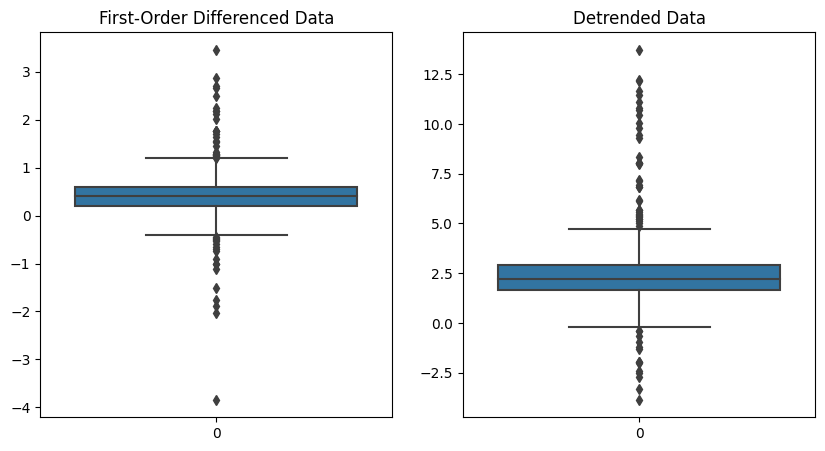

In [109]:
cus_boxplot(diff_data, detrend, 'First-Order Differenced Data', 'Detrended Data')

In [110]:
# Obtain the statistical attributes of both first-order differenced data and detrended data
def cus_describe(data1, data2, title1, title2):
    print(title1)
    print(data1.describe())
    print('-----------------------')
    print(title2)
    print(data2.describe())


In [111]:
cus_describe(diff_data, detrend, 'First-Order Differenced Data', 'Detrended Data')

First-Order Differenced Data
count    638.000000
mean       0.413649
std        0.519949
min       -3.842000
25%        0.200000
50%        0.400000
75%        0.600000
max        3.460000
Name: CPI, dtype: float64
-----------------------
Detrended Data
count    627.000000
mean       2.485391
std        1.865868
min       -3.858208
25%        1.633833
50%        2.185750
75%        2.916458
max       13.729208
dtype: float64


## 4. Lag Analysis

To identify the useful lag variables, we can use the autocorrelation function (ACF) and Partial Autocorrelation Function (PACF) plots.

The main difference between ACF and PACF is that ACF measures the total correlation between a time series and its lagged values, while PACF measures the direct correlation between a time series and its lagged values after removing the effect of the correlations with the intervening observations. 

ACF is primarily used to determine the MA component, while the PACF plot is used to determine the AR component.

The shaded area is the signifiance level in the ACF and PACF plots. If a lag is above the shaded area, it is significantly correlated with the label. 

### 4.1 First-Oder Differencing ACF and PACF

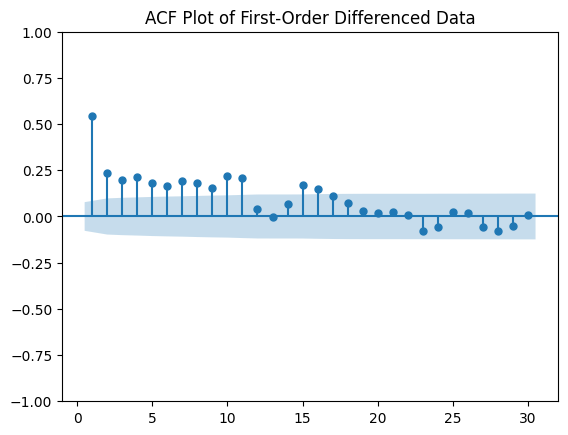

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


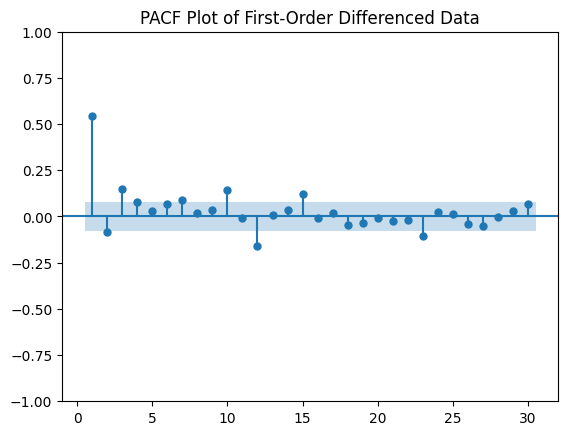

In [112]:
# ACF plot
plot_acf(diff_data, lags= 30, zero=False)
plt.title('ACF Plot of First-Order Differenced Data')
plt.show()

# PACF plot
plot_pacf(diff_data, lags = 30, zero=False)
plt.title('PACF Plot of First-Order Differenced Data')
plt.show()

### 4.2 Detrending ACF and PACF

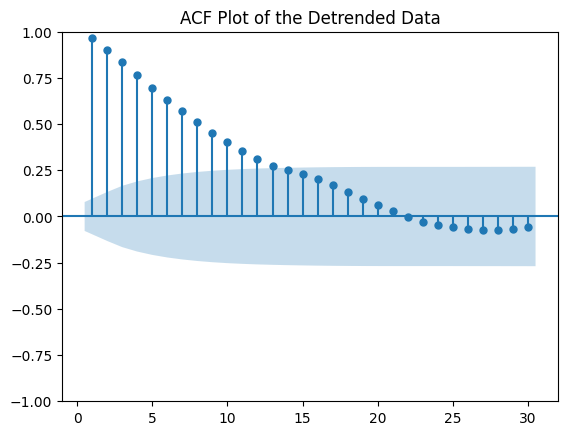

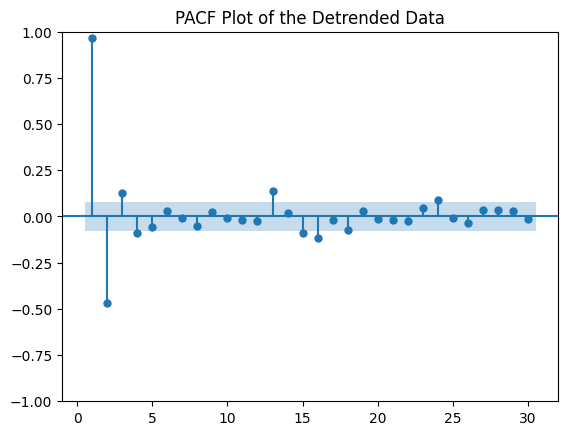

In [113]:
# ACF plot
plot_acf(detrend, lags= 30, zero=False)
plt.title('ACF Plot of the Detrended Data')
plt.show()

# PACF plot
plot_pacf(detrend, lags = 30, zero=False)
plt.title('PACF Plot of the Detrended Data')
plt.show()

### 4.3 Lag Analysis Conclusion 

- In the First-Order Differenced ACF, there is a significant autocorrelation between the current observation and its its first 11 lagged values. Meanwhile, lags of 1, 3, 10, 12 are found to have a direct relationship with the label in PACF.

- In detreneded data, there is a significant autocorrelation between the current CPI and the first 12 lagged values, while lag of 1, 2, 3, 13 shows a significantly direct relationship with the current observation of CPI.  

- These analysis also reveals that even though the seasonality effect is not so obvious on the data visualization, it still has a significant correlation with the current values . 

## 5. ARIMA(1,1,1)